In [131]:
import guitarpro
from guitarpro import *
import pandas as pd

from _Decompressor import decompress_track

In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas
import pickle
import glob
from __future__ import print_function, division
from keras.layers import Input, Dense, Reshape, Dropout, CuDNNLSTM, LSTM, Bidirectional
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils

## Constants

In [129]:
MIDI  = {str(GuitarString(number=0, value=val)) : val for val in range(128)}

In [ ]:
def generate_notes(model, network_input, n_vocab):
    """ Generate notes from the neural network based on a sequence of notes """
    # pick a random sequence from the input as a starting point for the prediction
    start = numpy.random.randint(0, len(network_input)-1)
    
    # Get pitch names and store in a dictionary
    pitchnames = sorted(set(item for item in notes))
    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    # generate 500 notes
    for note_index in range(500):
        prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = numpy.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)
        
        pattern = numpy.append(pattern,index)
        #pattern.append(index)
        pattern = pattern[1:len(pattern)]

    return prediction_output

In [ ]:
def create_midi(prediction_output, filename):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for item in prediction_output:
        pattern = item[0]
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='{}.mid'.format(filename))

## Load Data

In [88]:
with open('network_data', 'rb') as filepath:
    network_input = pickle.load(filepath)
    network_output = pickle.load(filepath)
    n_vocab = pickle.load(filepath)

In [89]:
with open('notes', 'rb') as filepath:
    notes = pickle.load(filepath)

with open('note_int_conversions', 'rb') as filepath:
    note_to_int = pickle.load(filepath)
    int_to_note = pickle.load(filepath)

In [103]:
class GAN():
    def __init__(self, rows):
        self.seq_length = rows
        self.seq_shape = (self.seq_length, 1)
        self.latent_dim = 1000
        self.disc_loss = []
        self.gen_loss =[]
        
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates note sequences
        z = Input(shape=(self.latent_dim,))
        generated_seq = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(generated_seq)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_discriminator(self):

        model = Sequential()
        #model.add(CuDNNLSTM(512, input_shape=self.seq_shape, return_sequences=True))
        #model.add(Bidirectional(CuDNNLSTM(512)))
        model.add(LSTM(512, input_shape=self.seq_shape, return_sequences=True))
        model.add(Bidirectional(LSTM(512)))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        seq = Input(shape=self.seq_shape)
        validity = model(seq)

        return Model(seq, validity)
      
    def build_generator(self):

        model = Sequential()
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.seq_shape), activation='sigmoid'))
        model.add(Reshape(self.seq_shape))
        model.summary()
        
        noise = Input(shape=(self.latent_dim,))
        seq = model(noise)

        return Model(noise, seq)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load and convert the data
        X_train = network_input
        y_train = network_output

        # Adversarial ground truths
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        # Training the model
        for epoch in range(epochs):

            # Training the discriminator
            # Select a random batch of note sequences
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_seqs = X_train[idx]

            #noise = np.random.choice(range(484), (batch_size, self.latent_dim))
            #noise = (noise-242)/242
            #noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            noise = np.random.uniform(0, 1, (batch_size, self.latent_dim))
            
            # Generate a batch of new note sequences
            gen_seqs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(real_seqs, real)
            d_loss_fake = self.discriminator.train_on_batch(gen_seqs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            #  Training the Generator
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as real)
            g_loss = self.combined.train_on_batch(noise, real)

            # Print the progress and save into loss lists
            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.disc_loss.append(d_loss[0])
                self.gen_loss.append(g_loss)
        
        self.generate()
        self.plot_loss()
        
    def generate(self):
        
        # Use random noise to generate sequences
        noise = np.random.normal(0, 1, (1, self.latent_dim))
        predictions = self.generator.predict(noise)
        
        pred_notes = [x*242+242 for x in predictions[0]]
        #pred_notes = [int_to_note[int(x)] for x in pred_notes]
        
        # create_midi(pred_notes, 'gan_final')
        
    def plot_loss(self):
        plt.plot(self.disc_loss, c='red')
        plt.plot(self.gen_loss, c='blue')
        plt.title("GAN Loss per Epoch")
        plt.legend(['Discriminator', 'Generator'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig('GAN_Loss_per_Epoch_final.png', transparent=True)
        plt.close()

In [118]:
gan = GAN(rows=100)   
# epochs = 5000
gan.train(epochs=10, batch_size=32, sample_interval=1)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 100, 512)          1052672   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 1024)              4198400   
_________________________________________________________________
dense_35 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)               

In [119]:
#noise = np.random.normal(0, 1, (1, gan.latent_dim))
noise = np.random.uniform(0, 1, (1, gan.latent_dim))
pred = gan.generator.predict(noise)[0]
pred *= n_vocab

(array([82.03833], dtype=float32), array([376.0931], dtype=float32))

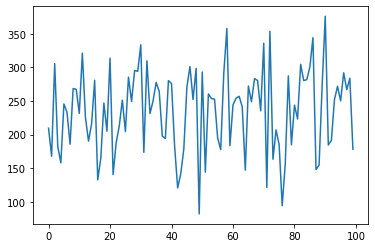

In [120]:
plt.plot(pred)
min(pred), max(pred)

In [122]:
prediction_output = [int_to_note[x] for x in np.round(pred.flatten())]

In [124]:
def thirty_seconds_to_duration(count):
    if count % 3 == 0:
        # If the note is dotted, do 32 / (i * 2/3), and return isDotted = True.
        return (48//count, True)
    else:
        # If the note is not dotted, to 32 / i, and return isDotted = False.
        return (32//count, False)

def quantize_thirty_seconds(value):

    # 32nd-note values of each fundamental type of note (not including 64th-notes, of course).
    vals = np.array([32, # whole
                     24, # dotted half
                     16, # half
                     12, # dotted quarter
                     8,  # quarter
                     6,  # dotted eigth
                     4,  # eigth
                     3,  # dotted sixteenth
                     2,  # sixteenth
                     1]) # thirty-second
    
    list_out = []

    for v in vals:
        if v <= value:
            list_out.append(thirty_seconds_to_duration(v))
            value -= v
            
    return np.array(list_out)

## Adjust prediction output to 4/4 time

In [125]:
# This will be the prediction output
new_prediction_output = []


time = 0
for beat in prediction_output:
    
    # Calculate the fraction of a measure encompassed by the current beat / chord.
    beat_time = (1 / beat[1]) * (1 + 0.5 * beat[2])
    
    # Calculate the fraction of a measure taken up by all notes in the measure.
    # Calculate any residual time to see if this measure (in 4/4 time) is longer than 1 measure.
    measure_time = time + beat_time
    leftover_time = (measure_time) % 1
    
    # If the measure count (i.e., the measure integer) has changed and there is significant left-over beat time:
    if (int(measure_time) > int(time)) and (leftover_time > 1/128):
        
        # Calculate the initial 32nd notes encompassed by this beat in the current measure.
        this_measure_thirty_seconds = int(32 * (1 - time % 1))
        # Calculate the remaining 32nd notes encompassed by this beat in the next measure.
        next_measure_thirty_seconds = int(32 * leftover_time)
        
        # Get the Duration object parameters for this measure and the next measure.
        this_measure_durations = quantize_thirty_seconds(this_measure_thirty_seconds)
        next_measure_durations = quantize_thirty_seconds(next_measure_thirty_seconds)
        
        
        #print(f'{{ {32 / beat[1]}')
        for duration_idx, duration in enumerate(this_measure_durations):
            time += (1 / duration[0]) * (1 + 0.5 * duration[1])
            
            #print(time, '\t', time * 32)
                
            chord = beat[0] if duration_idx == 0 else 'tied'
            
            new_prediction_output.append((chord, duration[0], duration[1]))
            
            
        for duration in next_measure_durations:
            time += (1 / duration[0]) * (1 + 0.5 * duration[1])
            
            #print(time, '\t', time * 32)
            
            new_prediction_output.append(('tied', duration[0], duration[1]))
            
               
        continue
    
    
    time += beat_time
    new_prediction_output.append((beat[0], beat[1], beat[2]))
    
    #print(time, '\t', time * 32)


'''
time = 0
time2 = 0
idx = 0

for idx2, beat2 in enumerate(new_prediction_output[:100]):
    beat = prediction_output[idx]
    
    if time == time2:
        print(beat[0], '\t', time, '\t\t', beat2[0], '\t', time2)
        
        idx += 1
        
        time += (1 / beat[1]) * (1 + 0.5 * beat[2])
    
    else:
        print('\t\t\t\t', beat2[0], '\t', time2)

    
    
    time2 += (1 / beat2[1]) * (1 + 0.5 * beat2[2])
''';

## Separate prediction output notes into measures

In [126]:
# Use the previously calculated cumulative time as the number of measures in the new 4/4 song.
num_measures = int(np.ceil(time))

song = np.empty(num_measures, dtype=object)

time = 0
m_idx = 0

timestamps = []

for beat in new_prediction_output:
    #print(time)
    timestamps.append(time)
    
    m_idx = int(time)
    
    if song[m_idx] is None:
        
        song[m_idx] = [beat]
    else:
        song[m_idx].append(beat)
    
    
    time += (1 / beat[1]) * (1 + 0.5 * beat[2])
    
    
print(f'4/4 adjusted correctly: {set(range(num_measures)).issubset(set(timestamps))}')

4/4 adjusted correctly: False


## Figure out the necessary guitar tuning for the produced song

In [130]:
# Get the tuning (i.e., the lowest note) of the song:

'''
pitchnames = set([x[0] for x in prediction_output])
pitchnames.discard('rest')
pitchnames.discard('tied')
pitchnames.discard('dead')


# Standard tuning
tuning = {1: MIDI['E4'],
          2: MIDI['B3'],
          3: MIDI['G3'],
          4: MIDI['D3'],
          5: MIDI['A2'],
          6: MIDI['E2']}

# Get the lowest note in the output.
# The highest tuning allowed will be standard tuning.
lowest_note = min([MIDI[x.split('_')[0]] for x in pitchnames])
lowest_note = min(lowest_note, MIDI['E2'])

if lowest_note <= MIDI['B1']:
    # 7-string guitar case
    tuning[7] = MIDI['B1']
    drop = MIDI['B1'] - lowest_note
else:
    # drop the tuning by however much is necessary.
    drop = MIDI['E2'] - lowest_note
    
tuning = {k: v - drop for k, v in tuning.items()}
tuning
'''

# Standard tuning
tuning = {1: MIDI['E4'],
          2: MIDI['B3'],
          3: MIDI['G3'],
          4: MIDI['D3'],
          5: MIDI['A2'],
          6: MIDI['E2']}
tuning

{1: 64, 2: 59, 3: 55, 4: 50, 5: 45, 6: 40}

## Lastly, save the song to a .gp5 file

In [132]:
guitarpro.write(decompress_track(song, tuning), '_generation_gan.gp5')
print('Finished')

'''
TODO: Find out which song / where test sequence sources are coming from.

TODO: Normalize sequences based on lowest tuning notes to reduce overfitting.
TODO: After implementing tuning normalization, decide the tuning of the generated song based on the tuning of the input sequence.

TODO: Consider filtering out bass parts.

TODO: Train with a wider variety of songs once the generation process has been examined.
TODO: If training does not yield true creativity, try generating sequences using the random sequence initialization.
''';

Finished
